In [163]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, SelectFromModel, chi2
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GroupKFold, StratifiedKFold, GridSearchCV, ShuffleSplit, RandomizedSearchCV, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score,auc, accuracy_score
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, KMeansSMOTE, SMOTENC, SVMSMOTE,BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.utils import resample
import re
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings; warnings.simplefilter('ignore')

In [2]:
raw_transaction = pd.read_csv('..\\new_fraud_train_transaction.csv')
raw_identity = pd.read_csv('..\\train_identity.csv')

In [3]:
raw_transaction.head(4)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#If more that 70% of the raws in a column are missing/nan values we will get rid of the column
print('Number of columns of original dataset of transactions:',len(raw_transaction.columns))
raw_transaction_column_names_with_may_nan_values = []
for column_name in raw_transaction.columns:
    if raw_transaction[column_name].isna().sum() > 0.7*len(raw_transaction):
        raw_transaction_column_names_with_may_nan_values.append(column_name)
print('Amount of columns we will remove due to many NaN values:',len(raw_transaction_column_names_with_may_nan_values))

Number of columns of original dataset of transactions: 394
Amount of columns we will remove due to many NaN values: 168


In [5]:
#Let's see what is going on with the raws
print(len(raw_transaction))
len(raw_transaction.dropna(how='all'))

590540


590540

In [6]:
transactions = raw_transaction.drop(columns = raw_transaction_column_names_with_may_nan_values)
print(len(transactions.columns))

226


In [7]:
raw_identity .head(4)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN


In [8]:
#If more that 70% of the raws in a column are missing/nan values we will get rid of the column
print('Number of columns of original dataset of transactions:',len(raw_identity.columns))
raw_identity_column_names_with_may_nan_values = []
for column_name in raw_identity.columns:
    if raw_identity [column_name].isna().sum() > 0.7*len(raw_identity):
        raw_identity_column_names_with_may_nan_values.append(column_name)
print('Amount of columns we will remove due to many NaN values:',len(raw_identity_column_names_with_may_nan_values))

Number of columns of original dataset of transactions: 41
Amount of columns we will remove due to many NaN values: 9


#### WoW! Amost halft of the columns we will be removed because of the huge amount of NaN values

In [9]:
#Let's see what is going on with the raws
print(len(raw_identity))
len(raw_identity.dropna(how='all'))

144233


144233

In [10]:
identity = raw_identity.drop(columns = raw_identity_column_names_with_may_nan_values)
print(len(identity.columns))

32


In [11]:
identity.iloc[4:7, 0:20]

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_28
4,2987016,0,7460.0,0.0,0.0,1.0,0.0,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,Found
5,2987017,-5,61141.0,3.0,0.0,3.0,0.0,3.0,0.0,100.0,NotFound,52.0,-300.0,Found,Found,166.0,18.0,529.0,600.0,Found
6,2987022,-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NotFound,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
identity.iloc[4:7, 20:32]

,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
4,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS
5,Found,Windows 10,chrome 62.0,24.0,1366x768,match_status:2,T,F,T,T,desktop,Windows
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
#we want 1/3 or 10 of the cells in a raw not have missing values
identity = identity.dropna(thresh = 10 )
len(identity)

140985

#### Nice! There aren't any raws with all the columns missing values. However, this is not enough!

#### Transform Categorical columns in Transactions Dataset

In [14]:
numerical_columns = transactions._get_numeric_data().columns

In [15]:
categorical_columns = list(set(transactions.columns) - set(numerical_columns))

In [16]:
mails = []
for categorical_column in categorical_columns:
    if len(transactions[categorical_column ].value_counts()) ==2:
        transactions[str(categorical_column + '_true')] = transactions[categorical_column].map({'F':0,'NaN':0, 'T':1}).fillna(0)
    elif categorical_column == 'card6':
        transactions[str(categorical_column + '_debit')] = transactions[categorical_column].map({'debit':1, 'credit':0, 
                                                                                                'charge card':0, 
                                                                                                 'debit or credit':0 }).fillna(0)
    elif categorical_column == 'M4':
        transactions[str(categorical_column + '_M0')] = transactions[categorical_column].map({'M0':1, 'M1':0, 'M2':0}).fillna(0)
    
    elif categorical_column == 'ProductCD':
        transactions[str(categorical_column + '_W')] = transactions[categorical_column].map({'W':1, 'C':0, 'R':0, 'H':0, 
                                                                                             'S':0}).fillna(0)
    elif categorical_column == 'card4':
        transactions[str(categorical_column + '_visa')] = transactions[categorical_column].map({'visa':1, 'mastercard':0,
                                                                                                'american express':0, 
                                                                                                'discover':0}).fillna(0)
    elif categorical_column == 'P_emaildomain':
        for mail in transactions['P_emaildomain']:
            if mail == 'gmail.com' or mail=='yahoo.com':
                mails.append(1)
            else:
                mails.append(0)
        transactions[str(categorical_column + '_gmail/yahoo')] = mails
                

In [17]:
transactions= transactions.drop(columns =categorical_columns)

In [18]:
transactions.head(4)

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,...,M1_true,ProductCD_W,card4_visa,M5_true,M6_true,M4_M0,M3_true,M2_true,card6_debit,P_emaildomain_gmail/yahoo
0,2987000,0,86400,68.5,13926,NaN,150.0,142.0,315.0,87.0,...,1.0,1,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0
1,2987001,0,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,...,0.0,1,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1
2,2987002,0,86469,59.0,4663,490.0,150.0,166.0,330.0,87.0,...,1.0,1,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0
3,2987003,0,86499,50.0,18132,567.0,150.0,117.0,476.0,87.0,...,0.0,1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1


In [19]:
test = transactions._get_numeric_data().columns

In [20]:
len(test)

226

In [21]:
len(transactions.columns)

226

#### Transform Categorical columns in Identity Dataset

In [22]:
numerical_columns_identity = identity._get_numeric_data().columns

In [23]:
len(numerical_columns_identity)

17

In [24]:
categorical_columns_identity = list(set(identity.columns) - set(numerical_columns_identity))
len(categorical_columns_identity)

15

In [25]:
for cat_column in categorical_columns_identity:
    if len(identity[cat_column].value_counts()) ==2 and 'NotFound' in identity[cat_column].value_counts().index.tolist():
        identity[str(cat_column + '_found')] = identity[cat_column].map({'Found':1, 'NotFound':0}).fillna(0)
    
    elif len(identity[cat_column].value_counts()) ==2 and 'New' in identity[cat_column].value_counts().index.tolist():
        identity[str(cat_column + '_found')] = identity[cat_column].map({'Found':1, 'New':0}).fillna(0)
        
    elif len(identity[cat_column].value_counts()) ==3 and 'New' in identity[cat_column].value_counts().index.tolist():
        identity[str(cat_column + '_found')] = identity[cat_column].map({'Found':1, 'New':0, 'Unknown':0}).fillna(0)
        
    elif len(identity[cat_column].value_counts()) ==2 and identity[cat_column].value_counts().index.tolist() == ['T', 'F'] or identity[cat_column].value_counts().index.tolist() == ['F', 'T']:
        identity[str(cat_column + '_true')] = identity[cat_column].map({'T':1, 'F':0}).fillna(0)
        
    elif len(identity[cat_column].value_counts()) ==2 and 'desktop' in identity[cat_column].value_counts().index.tolist():
        identity[str(cat_column + '_desktop')] = identity[cat_column].map({'desktop':1, 'mobile':0}).fillna(0)
        
    elif len(identity[cat_column].value_counts()) ==4:
        identity[str(cat_column + '_match_status:2')] = identity[cat_column].map({'match_status:2':1, 'match_status:1':0,
                                                                                 'match_status:0':0, 'match_status:-1':0
                                                                                 }).fillna(0)
    else:
        print(cat_column)
        

id_33
id_31
id_30
DeviceInfo


In [26]:
deviceInfo_map = []
for device_info in identity['DeviceInfo']:
    if device_info == 'Windows':
        deviceInfo_map.append(1)
    else:
        deviceInfo_map.append(0)

In [27]:
identity['DeviceInfo_windows'] = deviceInfo_map

In [28]:
id30_ios_map = []
for id30 in identity['id_30']:
    if re.match(r'^iOS', str(id30)):
        id30_ios_map.append(1)
    else:
        id30_ios_map.append(0)

In [29]:
identity['id_30_ios'] = id30_ios_map

In [30]:
id31_chrome_map = []
for id31 in identity['id_31']:
    if re.match(r'^chrome', str(id31)):
        id31_chrome_map.append(1)
    else:
        id31_chrome_map.append(0)

In [31]:
identity['id_31_chrome'] = id31_chrome_map

In [32]:
resolution = []
for reso in identity['id_33']:
    if reso == '1920x1080':
        resolution.append(1)
    else:
        resolution.append(0)

In [33]:
identity['id_33_resolution'] = resolution

In [34]:
identity= identity.drop(columns =categorical_columns_identity)

In [35]:
len(identity), len(identity.columns)

(140985, 32)

### Join 2 datasets

In [36]:
for column_name in identity.columns:
    if column_name in transactions.columns:
        print(column_name)

TransactionID


In [37]:
merged = pd.merge(transactions, identity, on='TransactionID')

In [38]:
len(merged)

140985

In [39]:
merged.isFraud.value_counts()

0    129763
1     11222
Name: isFraud, dtype: int64

In [40]:
11222/len(merged)

0.07959712026102067

In [41]:
merged = merged.drop(columns=['TransactionID', 'TransactionDT'])

### NAN Imputation

In [42]:
new_merged = merged

In [43]:
for column_name in new_merged.columns:
    if (new_merged[column_name].isna().sum()/len(new_merged)) >0.55:
        print(column_name)

dist1
D2
D3
D5
D11
V1
V2
V3
V4
V5
V6
V7
V8
V9
V10
V11
id_18


In [44]:
len(new_merged)

140985

In [45]:
new_merged = new_merged.dropna(thresh = 80 )
len(new_merged)

140985

In [46]:
80/239

0.33472803347280333

In [47]:
#If more that 70% of the raws in a column are missing/nan values we will get rid of the column
print('Number of columns of merged dataset:',len(new_merged.columns))
new_merged_column_names_with_many_nan_values = []
for column_name in new_merged.columns:
    if new_merged[column_name].isna().sum() > 0.6*len(new_merged):
        new_merged_column_names_with_many_nan_values.append(column_name)
print('Amount of columns we will remove due to many NaN values:',len(new_merged_column_names_with_many_nan_values ))

Number of columns of merged dataset: 255
Amount of columns we will remove due to many NaN values: 17


In [48]:
for column_name in new_merged.columns:
    if new_merged[column_name].dtypes not in ['int', 'float', 'int64']:
        print((new_merged[column_name].min(), new_merged[column_name].max() ))
        print((new_merged[column_name].dtypes))        

In [49]:
columns_whose_distribution_lost = []
for column_name in new_merged.columns:
    if new_merged[column_name].min() == new_merged[column_name].max():
        columns_whose_distribution_lost.append(column_name)

In [50]:
len(columns_whose_distribution_lost)

29

Plotting for column C5


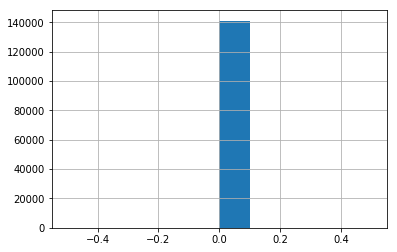

Plotting for column C9


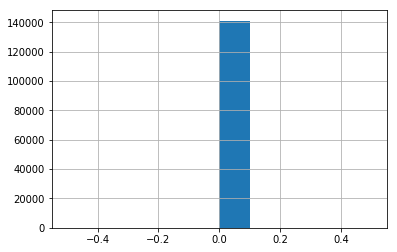

Plotting for column V12


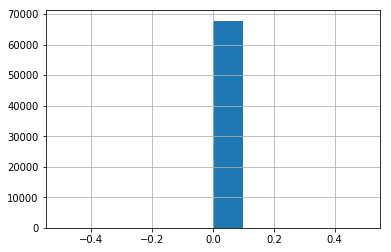

Plotting for column V13


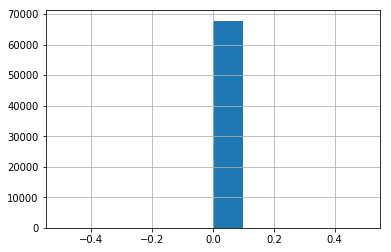

Plotting for column V29


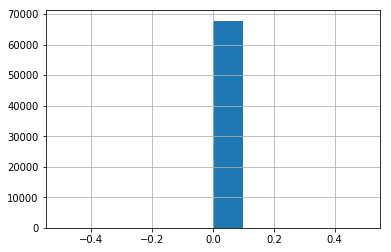

Plotting for column V30


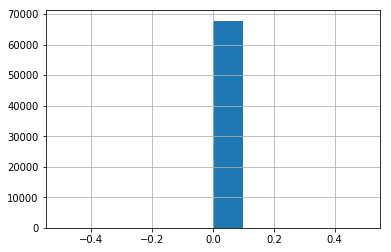

Plotting for column V35


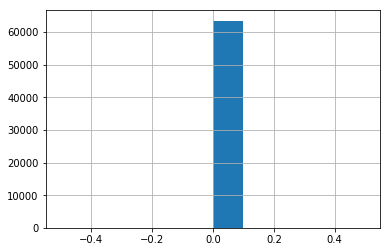

Plotting for column V36


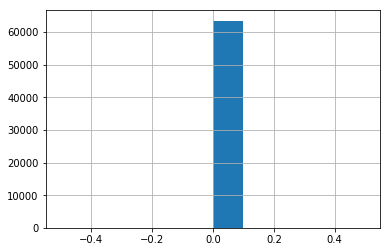

Plotting for column V48


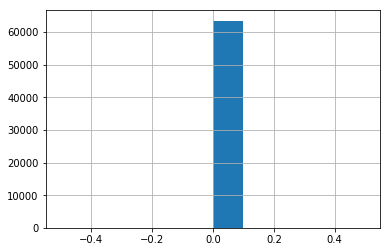

Plotting for column V49


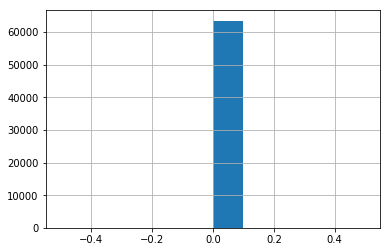

Plotting for column V53


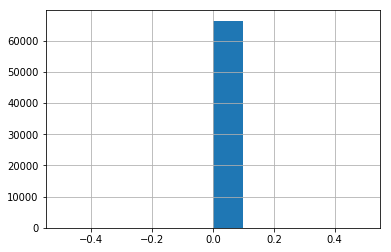

Plotting for column V54


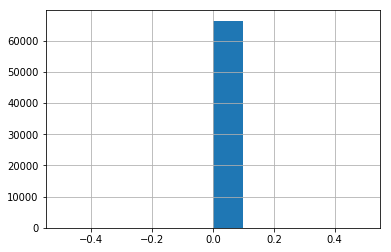

Plotting for column V69


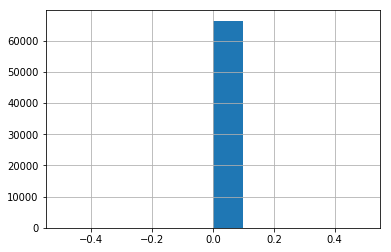

Plotting for column V70


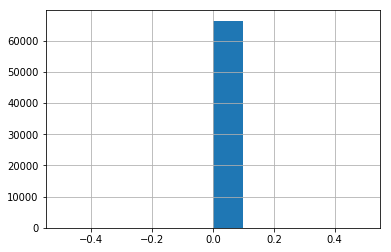

Plotting for column V75


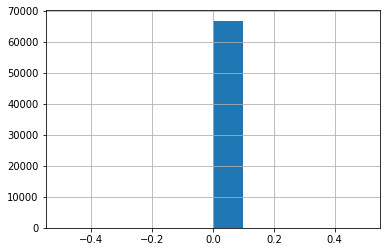

Plotting for column V76


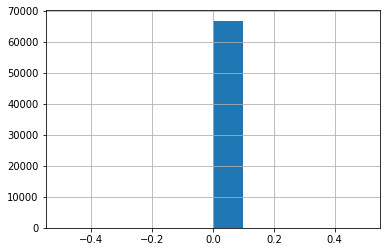

Plotting for column V90


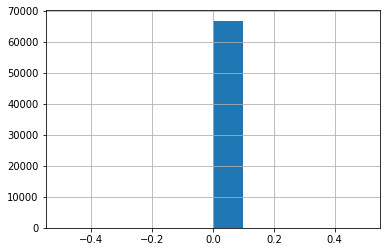

Plotting for column V91


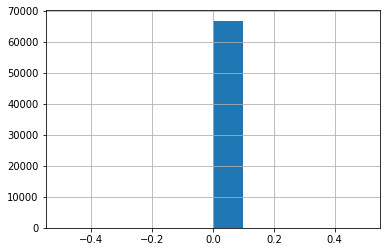

Plotting for column V107


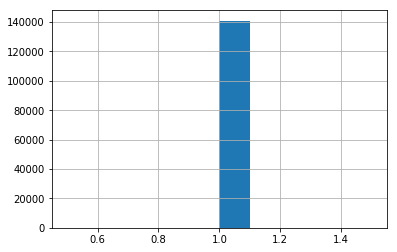

Plotting for column V305


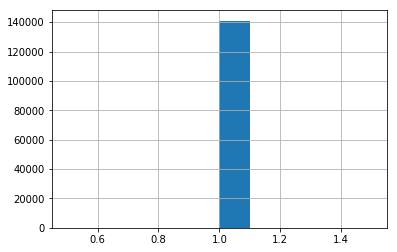

Plotting for column M9_true


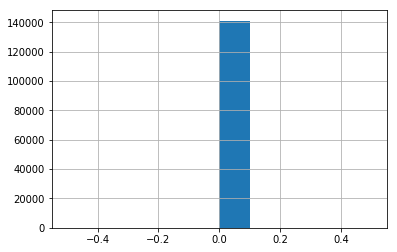

Plotting for column M7_true


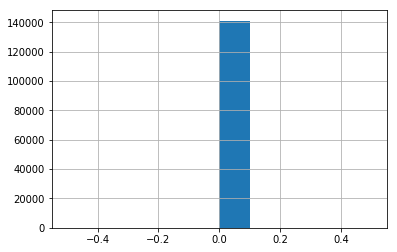

Plotting for column M8_true


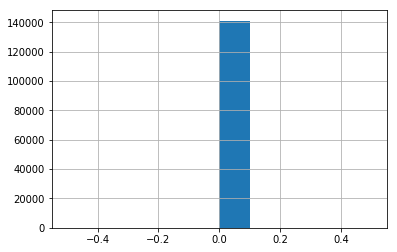

Plotting for column M1_true


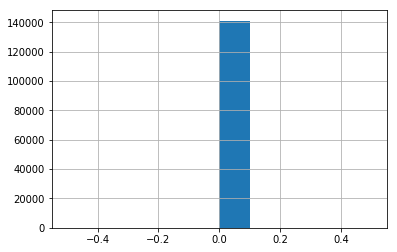

Plotting for column ProductCD_W


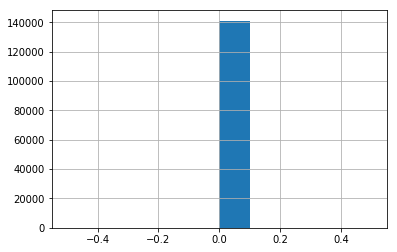

Plotting for column M5_true


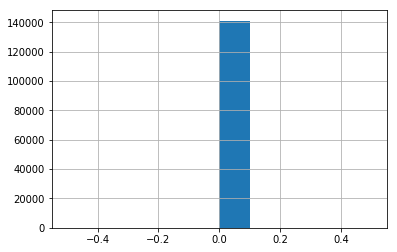

Plotting for column M6_true


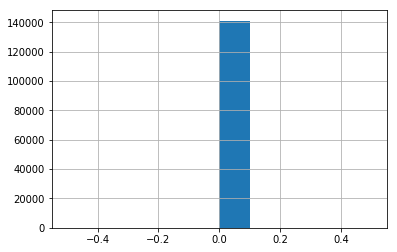

Plotting for column M3_true


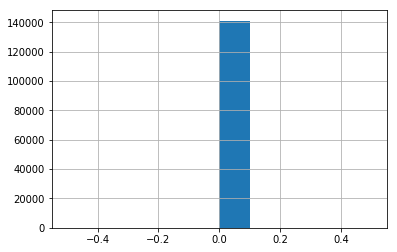

Plotting for column M2_true


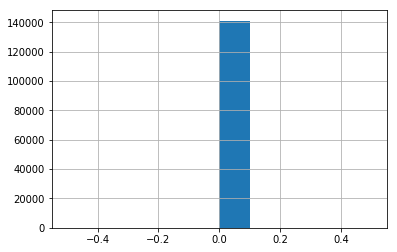

In [51]:
for col in columns_whose_distribution_lost:
    hist = new_merged[col].hist(bins=10)
    print("Plotting for column {}".format(col))
    plt.show()

In [52]:
new_merged= new_merged.drop(columns =columns_whose_distribution_lost)
len(new_merged.columns)

226

In [53]:
columns_with_nan_values = []
for col in new_merged.columns:
    if new_merged[col].isna().sum()!=0:
        print(col, new_merged[col].min(), new_merged[col].max(), new_merged[col].median())
        columns_with_nan_values.append(col)

card2 100.0 600.0 408.0
card3 100.0 231.0 150.0
card5 100.0 237.0 224.0
addr1 100.0 540.0 299.0
addr2 10.0 102.0 87.0
dist1 nan nan nan
D1 0.0 640.0 0.0
D2 0.0 640.0 37.0
D3 0.0 819.0 0.0
D4 -83.0 869.0 0.0
D5 0.0 819.0 0.0
D10 0.0 869.0 0.0
D11 nan nan nan
D15 -83.0 879.0 0.0
V1 nan nan nan
V2 nan nan nan
V3 nan nan nan
V4 nan nan nan
V5 nan nan nan
V6 nan nan nan
V7 nan nan nan
V8 nan nan nan
V9 nan nan nan
V10 nan nan nan
V11 nan nan nan
V14 0.0 1.0 1.0
V15 0.0 7.0 1.0
V16 0.0 15.0 1.0
V17 0.0 15.0 1.0
V18 0.0 15.0 1.0
V19 0.0 7.0 1.0
V20 0.0 15.0 1.0
V21 0.0 5.0 1.0
V22 0.0 8.0 1.0
V23 0.0 13.0 1.0
V24 0.0 13.0 1.0
V25 0.0 5.0 1.0
V26 0.0 10.0 1.0
V27 0.0 4.0 0.0
V28 0.0 4.0 0.0
V31 0.0 7.0 1.0
V32 0.0 15.0 1.0
V33 0.0 5.0 1.0
V34 0.0 10.0 1.0
V37 0.0 54.0 1.0
V38 0.0 54.0 1.0
V39 0.0 15.0 1.0
V40 0.0 24.0 1.0
V41 0.0 1.0 1.0
V42 0.0 8.0 1.0
V43 0.0 8.0 1.0
V44 0.0 48.0 1.0
V45 0.0 48.0 1.0
V46 0.0 6.0 1.0
V47 0.0 12.0 1.0
V50 0.0 5.0 1.0
V51 0.0 6.0 1.0
V52 0.0 12.0 1.0
V55 0.0 17

In [54]:
for col in columns_with_nan_values:
    if len(new_merged[col].dropna().unique())==2:
        print(new_merged[col].unique())

[nan  1.  0.]
[nan  1.  0.]
[nan  1.  0.]
[nan  1.  0.]
[nan  1.  0.]


In [55]:
columns_with_nan_values[3]


'addr1'

In [56]:
new_merged[columns_with_nan_values[3]].describe()

count    81667.000000
mean       296.882890
std         99.277648
min        100.000000
25%        204.000000
50%        299.000000
75%        330.000000
max        540.000000
Name: addr1, dtype: float64

In [57]:
impute_nan = pd.DataFrame(columns=new_merged.columns)

In [58]:
len(new_merged.columns)

226

In [59]:
new_merged['card2'].isna().sum()

880

In [60]:
impute_nan['card2'].isna().sum()

0

In [61]:
columns_to_be_deleted_many_nan = []
nomatter = []
for column_with_nan in new_merged.columns:
    if new_merged[column_with_nan].isna().sum() ==0:
        impute_nan[column_with_nan] = new_merged[column_with_nan]
    
    if new_merged[column_with_nan].isna().sum()>0 and new_merged[column_with_nan].isna().sum()<100:
        impute_nan[column_with_nan] = new_merged[column_with_nan].interpolate(method='pad', limit=3)
    
    if new_merged[column_with_nan].isna().sum()>=100 and new_merged[column_with_nan].isna().sum()<=80000:
        impute_nan[column_with_nan] = new_merged[column_with_nan].interpolate(method='linear', limit=220)
        
        if impute_nan[column_with_nan].isna().sum()!=0:
            columns_to_be_deleted_many_nan.append(column_with_nan)
        
            
    if new_merged[column_with_nan].isna().sum()> 80000:
        columns_to_be_deleted_many_nan.append(column_with_nan)

In [62]:
len(columns_to_be_deleted_many_nan)

94

In [63]:
impute_nan = impute_nan.drop(columns = columns_to_be_deleted_many_nan)

In [64]:
len(impute_nan.columns)

132

In [65]:
for col in impute_nan.columns:
    if impute_nan[col].isna().sum()!=0:
        print(col, impute_nan[col].isna().sum())

In [66]:
impute_nan.head(3)

,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,...,id_36_true,DeviceType_desktop,id_34_match_status:2,id_29_found,id_38_true,id_12_found,DeviceInfo_windows,id_30_ios,id_31_chrome,id_33_resolution
0,0,50.000,4497,514.0,150.0,102.0,420.000000,87.0,1,1,...,0,0.0,1.0,0.0,1,0,0,0,0,0
1,0,15.000,2803,100.0,150.0,226.0,337.000000,87.0,1,1,...,0,0.0,0.0,0.0,1,0,0,1,0,0
2,0,75.887,16496,352.0,117.0,134.0,281.333333,87.0,1,4,...,0,1.0,0.0,1.0,1,0,1,0,1,0


In [67]:
impute_nan['isFraud'].value_counts()

0    129763
1     11222
Name: isFraud, dtype: int64

### Feature Importance 

In [68]:
def feature_importance(df, column_split_predict):
    X = df.ix[:, df.columns != column_split_predict]
    y = df.ix[:, df.columns == column_split_predict]
    
    fe = ExtraTreesClassifier(random_state=101)
    fe.fit(X,y)
    
    feat_importances = pd.Series(fe.feature_importances_, index=X.columns)
    feat_importances.nlargest(15).plot(kind='barh')
    plt.show()

In [69]:
def recursive_feature_elimination(df, column_split_predict):
    model = LogisticRegression()
    rfe = RFE(model, 12)
    
    X = df.ix[:, df.columns != column_split_predict]
    y = df.ix[:, df.columns == column_split_predict]
    
    fit = rfe.fit(X, y)
    print("Num Features: %s" % (fit.n_features_))
    print("Selected Features: %s" % (fit.support_))
    print("Feature Ranking: %s" % (fit.ranking_))
    
    important = fit.ranking_
    result = np.where(important == 1)
    df = df.iloc[:, result]
    return important

## Undersample based on fraud 50/50 ratio 

In [70]:
#UnderSampling Method, 50/50 ratio of fraud and normal transactions
num_fraud_records = len(impute_nan[impute_nan.isFraud ==1])
fraud_indices = np.array(impute_nan[impute_nan.isFraud == 1].index)
normal_indices = impute_nan[impute_nan.isFraud == 0].index
random_normal_indices = np.random.choice(normal_indices, num_fraud_records, replace = False)
random_normal_indices = np.array(random_normal_indices)
concate_indices = np.concatenate([fraud_indices,random_normal_indices])
balanced_sample_data = impute_nan.iloc[concate_indices,:]

In [71]:
X_undersample = balanced_sample_data.ix[:, balanced_sample_data.columns != 'isFraud']
y_undersample = balanced_sample_data.ix[:, balanced_sample_data.columns == 'isFraud']

In [72]:
list_lists_important_features = []

In [73]:
def log_feature_importance(X, Y):
    sel_ = SelectFromModel(LogisticRegression(C=0.1, penalty='l1'))
    sel_.fit(X, Y)
    sel_.get_support()
    selected_feat = X.columns[(sel_.get_support())]
    print('total features: {}'.format((X.shape[1])))
    print('selected features: {}'.format(len(selected_feat)))
    print('features with coefficients shrank to zero: {}'.format(
          np.sum(sel_.estimator_.coef_ == 0)))
    return selected_feat

In [74]:
selected_feat = log_feature_importance(X_undersample, y_undersample)

total features: 131
selected features: 94
features with coefficients shrank to zero: 35


In [75]:
len(selected_feat)

94

In [76]:
list_lists_important_features.append(selected_feat)

In [77]:
def lgbc_feature_importance(X, Y):
    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

    embeded_lgb_selector = SelectFromModel(lgbc)
    embeded_lgb_selector.fit(X, Y)
    embeded_lgb_support = embeded_lgb_selector.get_support()
    embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
    print(str(len(embeded_lgb_feature)), 'selected features')
    return embeded_lgb_feature

In [78]:
lgbc_important_features = lgbc_feature_importance(X_undersample, y_undersample)

33 selected features


In [79]:
list_lists_important_features.append(lgbc_important_features)

In [80]:
def randomForest_feature_importance(X, Y):
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100))
    embeded_rf_selector.fit(X, Y)
    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
    print(str(len(embeded_rf_feature)), 'selected features')
    return embeded_rf_feature

In [81]:
randomForest_important_features = randomForest_feature_importance(X_undersample, y_undersample)

30 selected features


In [82]:
list_lists_important_features.append(randomForest_important_features)

In [83]:
def chi2_feature_importance(X, Y):
    X_undersample_norm  = preprocessing.MinMaxScaler().fit_transform(X)
    chi_selector = SelectKBest(chi2, k=100)
    chi_selector.fit(X_undersample_norm, Y)

    chi_support = chi_selector.get_support()
    chi_feature = X.loc[:,chi_support].columns.tolist()
    print(str(len(chi_feature)), 'selected features')
    return chi_feature

In [84]:
chi2_important_features = chi2_feature_importance(X_undersample, y_undersample)

100 selected features


In [85]:
list_lists_important_features.append(chi2_important_features)

In [86]:
def correlation_feature_importance(X, Y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], Y.isFraud)[0, 1]
        cor_list.append(cor)

    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-29:]].columns.tolist()
    return cor_feature

In [87]:
correlation_important_features = correlation_feature_importance(X_undersample, y_undersample)

In [88]:
list_lists_important_features.append(correlation_important_features)

In [89]:
len(list_lists_important_features)

5

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X_undersample, y_undersample, test_size=0.30, random_state=59)

In [91]:
lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

lgbc.fit(X_train, y_train)

predictbalanc = lgbc.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predictbalanc)
roc_auc_lr_usf = auc(false_positive_rate, true_positive_rate)
print(roc_auc_lr_usf)
print(confusion_matrix(y_test,predictbalanc))

0.8808259254476312
[[3055  323]
 [ 479 2877]]


In [92]:
model = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                        min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                      nthread=4, scale_pos_weight=1, seed=27)
model.fit(X_train, y_train)

predictbalanc = model.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predictbalanc)
roc_auc_lr_usf = auc(false_positive_rate, true_positive_rate)
print(roc_auc_lr_usf)
print(confusion_matrix(y_test,predictbalanc))

0.8836275670026413
[[3085  293]
 [ 490 2866]]


In [93]:
for selected_feat in range(len(list_lists_important_features)):
    x_with_important_features = X_train[list_lists_important_features[selected_feat]]
  
    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)
    
    lgbc.fit(x_with_important_features, y_train)
  
    predictbalanc = lgbc.predict(X_test[list_lists_important_features[selected_feat]])
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predictbalanc)
    roc_auc_lr_usf = auc(false_positive_rate, true_positive_rate)
    print(roc_auc_lr_usf)
    print(confusion_matrix(y_test,predictbalanc))

0.8802260966458278
[[3059  319]
 [ 487 2869]]
0.8781509536219426
[[3048  330]
 [ 490 2866]]
0.8762092725064587
[[3053  325]
 [ 508 2848]]
0.878445046155062
[[3052  326]
 [ 492 2864]]
0.759759655655927
[[2686  692]
 [ 925 2431]]


In [94]:
for selected_feat in range(len(list_lists_important_features)):
    x_with_important_features = X_train[list_lists_important_features[selected_feat]]
  
    model = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                          min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                          nthread=4, scale_pos_weight=1, seed=27)
    
    model.fit(x_with_important_features, y_train)
  
    predictbalanc = model.predict(X_test[list_lists_important_features[selected_feat]])
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predictbalanc)
    roc_auc_lr_usf = auc(false_positive_rate, true_positive_rate)
    print(roc_auc_lr_usf)
    print(confusion_matrix(y_test,predictbalanc))

0.8852596306042534
[[3092  286]
 [ 486 2870]]
0.8840745276701025
[[3085  293]
 [ 487 2869]]
0.8810967305096216
[[3083  295]
 [ 505 2851]]
0.8821396387336979
[[3083  295]
 [ 498 2858]]
0.7658555040643693
[[2699  679]
 [ 897 2459]]


In [95]:
X= impute_nan.ix[:, impute_nan.columns != 'isFraud']
y= impute_nan.ix[:, impute_nan.columns == 'isFraud']

### ADASYN

In [96]:
method = ADASYN(sampling_strategy=1)
X_resampled, y_resampled = method.fit_sample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.30, random_state=59)

In [97]:
len(y_resampled)

261023

logbalanc= LogisticRegression(C=10, penalty='l1')
logbalanc.fit(X_train, y_train)

predictbalanc = logbalanc.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predictbalanc)
roc_auc_lr_usf = auc(false_positive_rate, true_positive_rate)
print(roc_auc_lr_usf)
print(confusion_matrix(y_test,predictbalanc))

In [98]:
lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

lgbc.fit(X_train, y_train)

predictbalanc = lgbc.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predictbalanc)
roc_auc_lr_usf = auc(false_positive_rate, true_positive_rate)
print(roc_auc_lr_usf)
print(confusion_matrix(y_test,predictbalanc))

0.9815265295729463
[[38858   278]
 [ 1169 38002]]


In [99]:
model = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                        min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                      nthread=4, scale_pos_weight=1, seed=27)

model.fit(X_train, y_train)

predict = model.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predict)
roc_auc_lr_usf = auc(false_positive_rate, true_positive_rate)
print(roc_auc_lr_usf)
print(confusion_matrix(y_test,predict))

0.9793177838002495
[[38816   320]
 [ 1300 37871]]


In [100]:
    X_train = pd.DataFrame(X_train, columns = X.columns)
    X_test = pd.DataFrame(X_test, columns = X.columns)

In [101]:
for selected_feat in range(len(list_lists_important_features)):
    x_with_important_features = X_train[list_lists_important_features[selected_feat]]
  
    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)
    
    lgbc.fit(x_with_important_features, y_train)
  
    predictbalanc = lgbc.predict(X_test[list_lists_important_features[selected_feat]])
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predictbalanc)
    roc_auc_lr_usf = auc(false_positive_rate, true_positive_rate)
    print(roc_auc_lr_usf)
    print(confusion_matrix(y_test,predictbalanc))

0.9812457438252218
[[38861   275]
 [ 1194 37977]]
0.9806457302919859
[[38854   282]
 [ 1234 37937]]
0.9800583671484191
[[38837   299]
 [ 1263 37908]]
0.9806457531230918
[[38856   280]
 [ 1236 37935]]
0.9595968126095672
[[38838   298]
 [ 2867 36304]]


In [102]:
for selected_feat in range(len(list_lists_important_features)):
    x_with_important_features = X_train[list_lists_important_features[selected_feat]]
  
    model = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                          min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                          nthread=4, scale_pos_weight=1, seed=27)
    
    model.fit(x_with_important_features, y_train)
  
    predictbalanc = model.predict(X_test[list_lists_important_features[selected_feat]])
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predictbalanc)
    roc_auc_lr_usf = auc(false_positive_rate, true_positive_rate)
    print(roc_auc_lr_usf)
    print(confusion_matrix(y_test,predictbalanc))

0.9793818120061997
[[38834   302]
 [ 1313 37858]]
0.9780151495034048
[[38759   377]
 [ 1345 37826]]
0.9779895176730294
[[38750   386]
 [ 1338 37833]]
0.9789728556910449
[[38791   345]
 [ 1302 37869]]
0.9579367938782494
[[38783   353]
 [ 2942 36229]]


### BorderLineSMOTE

In [103]:
method = BorderlineSMOTE(sampling_strategy='not minority')
X_resampled, y_resampled = method.fit_sample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.30, random_state=59)

In [104]:
len(X_resampled)

140985

In [105]:
lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

lgbc.fit(X_train, y_train)

predictbalanc = lgbc.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predictbalanc)
roc_auc_lr_usf = auc(false_positive_rate, true_positive_rate)
print(roc_auc_lr_usf)
print(confusion_matrix(y_test,predictbalanc))

0.8197765450235138
[[38662   291]
 [ 1180  2163]]


In [106]:
model = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                        min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                      nthread=4, scale_pos_weight=1, seed=27)

model.fit(X_train, y_train)

predict = model.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predict)
roc_auc_lr_usf = auc(false_positive_rate, true_positive_rate)
print(roc_auc_lr_usf)
print(confusion_matrix(y_test,predict))

0.8084095094267443
[[38662   291]
 [ 1256  2087]]


In [107]:
X_train = pd.DataFrame(X_train, columns = X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)

In [109]:
for selected_feat in range(len(list_lists_important_features)):
    x_with_important_features = X_train[list_lists_important_features[selected_feat]]
  
    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)
    
    lgbc.fit(x_with_important_features, y_train)
  
    predictbalanc = lgbc.predict(X_test[list_lists_important_features[selected_feat]])
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predictbalanc)
    roc_auc_lr_usf = auc(false_positive_rate, true_positive_rate)
    print(roc_auc_lr_usf)
    print(confusion_matrix(y_test,predictbalanc))

0.8192636663408356
[[38657   296]
 [ 1183  2160]]
0.8089179225853834
[[38655   298]
 [ 1252  2091]]
0.8112641043077609
[[38663   290]
 [ 1237  2106]]
0.8138664450763312
[[38656   297]
 [ 1219  2124]]
0.6082223321678866
[[38715   238]
 [ 2599   744]]


In [110]:
for selected_feat in range(len(list_lists_important_features)):
    x_with_important_features = X_train[list_lists_important_features[selected_feat]]
  
    model = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                          min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                          nthread=4, scale_pos_weight=1, seed=27)
    
    model.fit(x_with_important_features, y_train)
  
    predictbalanc = model.predict(X_test[list_lists_important_features[selected_feat]])
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predictbalanc)
    roc_auc_lr_usf = auc(false_positive_rate, true_positive_rate)
    print(roc_auc_lr_usf)
    print(confusion_matrix(y_test,predictbalanc))

0.8095161876167923
[[38655   298]
 [ 1248  2095]]
0.8065678359292593
[[38670   283]
 [ 1269  2074]]
0.8046619825226531
[[38673   280]
 [ 1282  2061]]
0.8034565214117576
[[38649   304]
 [ 1288  2055]]
0.6105729794143028
[[38735   218]
 [ 2585   758]]


### RandomOverSampler

In [111]:
method = RandomOverSampler(sampling_strategy='not majority')
X_resampled, y_resampled = method.fit_sample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.30, random_state=59)

In [112]:
len(X_resampled)

259526

In [113]:
lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

lgbc.fit(X_train, y_train)

predictbalanc = lgbc.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predictbalanc)
roc_auc_lr_usf = auc(false_positive_rate, true_positive_rate)
print(roc_auc_lr_usf)
print(confusion_matrix(y_test,predictbalanc))

0.9247219022717654
[[36739  2408]
 [ 3447 35264]]


In [114]:
model = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                        min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                      nthread=4, scale_pos_weight=1, seed=27)

model.fit(X_train, y_train)

predict = model.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predict)
roc_auc_lr_usf = auc(false_positive_rate, true_positive_rate)
print(roc_auc_lr_usf)
print(confusion_matrix(y_test,predict))

0.908465501503766
[[36434  2713]
 [ 4404 34307]]


In [115]:
X_train = pd.DataFrame(X_train, columns = X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)

In [116]:
for selected_feat in range(len(list_lists_important_features)):
    x_with_important_features = X_train[list_lists_important_features[selected_feat]]
  
    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)
    
    lgbc.fit(x_with_important_features, y_train)
  
    predictbalanc = lgbc.predict(X_test[list_lists_important_features[selected_feat]])
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predictbalanc)
    roc_auc_lr_usf = auc(false_positive_rate, true_positive_rate)
    print(roc_auc_lr_usf)
    print(confusion_matrix(y_test,predictbalanc))

0.919979808139161
[[36662  2485]
 [ 3738 34973]]
0.9189228661623474
[[36557  2590]
 [ 3716 34995]]
0.9158796718862635
[[36522  2625]
 [ 3917 34794]]
0.9168420591880236
[[36566  2581]
 [ 3886 34825]]
0.7900053761152662
[[31713  7434]
 [ 8907 29804]]


In [117]:
for selected_feat in range(len(list_lists_important_features)):
    x_with_important_features = X_train[list_lists_important_features[selected_feat]]
  
    model = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                          min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                          nthread=4, scale_pos_weight=1, seed=27)
    
    model.fit(x_with_important_features, y_train)
  
    predictbalanc = model.predict(X_test[list_lists_important_features[selected_feat]])
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predictbalanc)
    roc_auc_lr_usf = auc(false_positive_rate, true_positive_rate)
    print(roc_auc_lr_usf)
    print(confusion_matrix(y_test,predictbalanc))

0.9032113617024242
[[36325  2822]
 [ 4703 34008]]
0.9044454519850293
[[36276  2871]
 [ 4559 34152]]
0.9000704786356529
[[36161  2986]
 [ 4784 33927]]
0.9005576988355497
[[36186  2961]
 [ 4771 33940]]
0.7890039524283097
[[31671  7476]
 [ 8943 29768]]


### SMOTE

In [118]:
method = SMOTE(sampling_strategy='all')
X_resampled, y_resampled = method.fit_sample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.30, random_state=59)

In [119]:
len(X_resampled)

259526

In [120]:
lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

lgbc.fit(X_train, y_train)

predictbalanc = lgbc.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predictbalanc)
roc_auc_lr_usf = auc(false_positive_rate, true_positive_rate)
print(roc_auc_lr_usf)
print(confusion_matrix(y_test,predictbalanc))

0.9815324791676152
[[38859   288]
 [ 1145 37566]]


In [121]:
model = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                        min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                      nthread=4, scale_pos_weight=1, seed=27)

model.fit(X_train, y_train)

predict = model.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predict)
roc_auc_lr_usf = auc(false_positive_rate, true_positive_rate)
print(roc_auc_lr_usf)
print(confusion_matrix(y_test,predict))

0.9790082355789007
[[38808   339]
 [ 1290 37421]]


In [122]:
X_train = pd.DataFrame(X_train, columns = X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)

In [123]:
for selected_feat in range(len(list_lists_important_features)):
    x_with_important_features = X_train[list_lists_important_features[selected_feat]]
  
    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)
    
    lgbc.fit(x_with_important_features, y_train)
  
    predictbalanc = lgbc.predict(X_test[list_lists_important_features[selected_feat]])
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predictbalanc)
    roc_auc_lr_usf = auc(false_positive_rate, true_positive_rate)
    print(roc_auc_lr_usf)
    print(confusion_matrix(y_test,predictbalanc))

0.9809234026118195
[[38873   274]
 [ 1206 37505]]
0.980190054857265
[[38853   294]
 [ 1243 37468]]
0.9794435031682386
[[38835   312]
 [ 1283 37428]]
0.9803700188850082
[[38859   288]
 [ 1235 37476]]
0.9593576218934232
[[38843   304]
 [ 2846 35865]]


In [124]:
for selected_feat in range(len(list_lists_important_features)):
    x_with_important_features = X_train[list_lists_important_features[selected_feat]]
  
    model = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                          min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                          nthread=4, scale_pos_weight=1, seed=27)
    
    model.fit(x_with_important_features, y_train)
  
    predictbalanc = model.predict(X_test[list_lists_important_features[selected_feat]])
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predictbalanc)
    roc_auc_lr_usf = auc(false_positive_rate, true_positive_rate)
    print(roc_auc_lr_usf)
    print(confusion_matrix(y_test,predictbalanc))

0.9791630864286935
[[38809   338]
 [ 1279 37432]]
0.9774897313137877
[[38769   378]
 [ 1369 37342]]
0.9772367294250704
[[38732   415]
 [ 1352 37359]]
0.9782770456426687
[[38773   374]
 [ 1312 37399]]
0.9568365431049151
[[38770   377]
 [ 2969 35742]]


### SVMSMOTE

In [125]:
method = SVMSMOTE(sampling_strategy='minority')
X_resampled, y_resampled = method.fit_sample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.30, random_state=59)

In [126]:
len(X_resampled)

259526

In [127]:
lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

lgbc.fit(X_train, y_train)

predictbalanc = lgbc.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predictbalanc)
roc_auc_lr_usf = auc(false_positive_rate, true_positive_rate)
print(roc_auc_lr_usf)
print(confusion_matrix(y_test,predictbalanc))

0.9812210512133718
[[38869   278]
 [ 1179 37532]]


In [128]:
model = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                        min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                      nthread=4, scale_pos_weight=1, seed=27)

model.fit(X_train, y_train)

predict = model.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predict)
roc_auc_lr_usf = auc(false_positive_rate, true_positive_rate)
print(roc_auc_lr_usf)
print(confusion_matrix(y_test,predict))

0.9788529531654434
[[38810   337]
 [ 1304 37407]]


In [129]:
X_train = pd.DataFrame(X_train, columns = X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)

In [130]:
for selected_feat in range(len(list_lists_important_features)):
    x_with_important_features = X_train[list_lists_important_features[selected_feat]]
  
    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)
    
    lgbc.fit(x_with_important_features, y_train)
  
    predictbalanc = lgbc.predict(X_test[list_lists_important_features[selected_feat]])
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predictbalanc)
    roc_auc_lr_usf = auc(false_positive_rate, true_positive_rate)
    print(roc_auc_lr_usf)
    print(confusion_matrix(y_test,predictbalanc))

0.9808081635654426
[[38866   281]
 [ 1208 37503]]
0.9801003605525029
[[38848   299]
 [ 1245 37466]]
0.979791090416582
[[38843   304]
 [ 1264 37447]]
0.9803318456271407
[[38855   292]
 [ 1234 37477]]
0.9605982988009782
[[38838   309]
 [ 2745 35966]]


In [131]:
for selected_feat in range(len(list_lists_important_features)):
    x_with_important_features = X_train[list_lists_important_features[selected_feat]]
  
    model = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                          min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                          nthread=4, scale_pos_weight=1, seed=27)
    
    model.fit(x_with_important_features, y_train)
  
    predictbalanc = model.predict(X_test[list_lists_important_features[selected_feat]])
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predictbalanc)
    roc_auc_lr_usf = auc(false_positive_rate, true_positive_rate)
    print(roc_auc_lr_usf)
    print(confusion_matrix(y_test,predictbalanc))

0.9785558799821107
[[38810   337]
 [ 1327 37384]]
0.9775934926803507
[[38766   381]
 [ 1358 37353]]
0.9769003321474313
[[38736   411]
 [ 1382 37329]]
0.9780403818040573
[[38802   345]
 [ 1359 37352]]
0.9559835274973564
[[38684   463]
 [ 2950 35761]]


### RandomUnderSampler

In [132]:
method = RandomUnderSampler(random_state=12)
X_resampled, y_resampled = method.fit_sample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.30, random_state=59)

In [133]:
len(X_resampled)

22444

In [134]:
lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

lgbc.fit(X_train, y_train)

predictbalanc = lgbc.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predictbalanc)
roc_auc_lr_usf = auc(false_positive_rate, true_positive_rate)
print(roc_auc_lr_usf)
print(confusion_matrix(y_test,predictbalanc))

0.888547486329196
[[3055  301]
 [ 450 2928]]


In [135]:
model = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                        min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                      nthread=4, scale_pos_weight=1, seed=27)

model.fit(X_train, y_train)

predict = model.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predict)
roc_auc_lr_usf = auc(false_positive_rate, true_positive_rate)
print(roc_auc_lr_usf)
print(confusion_matrix(y_test,predict))

0.8901979858454517
[[3078  278]
 [ 462 2916]]


In [136]:
X_train = pd.DataFrame(X_train, columns = X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)

In [137]:
for selected_feat in range(len(list_lists_important_features)):
    x_with_important_features = X_train[list_lists_important_features[selected_feat]]
  
    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)
    
    lgbc.fit(x_with_important_features, y_train)
  
    predictbalanc = lgbc.predict(X_test[list_lists_important_features[selected_feat]])
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predictbalanc)
    roc_auc_lr_usf = auc(false_positive_rate, true_positive_rate)
    print(roc_auc_lr_usf)
    print(confusion_matrix(y_test,predictbalanc))

0.8842394805905986
[[3039  317]
 [ 463 2915]]
0.883193661432631
[[3029  327]
 [ 460 2918]]
0.8830437042321804
[[3027  329]
 [ 459 2919]]
0.8857244979256509
[[3044  312]
 [ 458 2920]]
0.7617405902738819
[[2642  714]
 [ 891 2487]]


In [138]:
for selected_feat in range(len(list_lists_important_features)):
    x_with_important_features = X_train[list_lists_important_features[selected_feat]]
  
    model = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                          min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                          nthread=4, scale_pos_weight=1, seed=27)
    
    model.fit(x_with_important_features, y_train)
  
    predictbalanc = model.predict(X_test[list_lists_important_features[selected_feat]])
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predictbalanc)
    roc_auc_lr_usf = auc(false_positive_rate, true_positive_rate)
    print(roc_auc_lr_usf)
    print(confusion_matrix(y_test,predictbalanc))

0.8864936901538455
[[3074  282]
 [ 483 2895]]
0.886481076106984
[[3061  295]
 [ 470 2908]]
0.8832140379698689
[[3050  306]
 [ 481 2897]]
0.8852843294372688
[[3048  308]
 [ 465 2913]]
0.7648819289929719
[[2676  680]
 [ 904 2474]]


# NearMiss

In [139]:
method = NearMiss(random_state=12)
X_resampled, y_resampled = method.fit_sample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.30, random_state=59)

In [140]:
len(X_resampled)

22444

logbalanc= LogisticRegression(C=10, penalty='l1')
logbalanc.fit(X_train, y_train)

predictbalanc = logbalanc.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predictbalanc)
roc_auc_lr_usf = auc(false_positive_rate, true_positive_rate)
print(roc_auc_lr_usf)
print(confusion_matrix(y_test,predictbalanc))

In [141]:
lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

lgbc.fit(X_train, y_train)

predictbalanc = lgbc.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predictbalanc)
roc_auc_lr_usf = auc(false_positive_rate, true_positive_rate)
print(roc_auc_lr_usf)
print(confusion_matrix(y_test,predictbalanc))

0.9142358604473594
[[3139  217]
 [ 361 3017]]


In [142]:
model = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                        min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                      nthread=4, scale_pos_weight=1, seed=27)

model.fit(X_train, y_train)

predict = model.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predict)
roc_auc_lr_usf = auc(false_positive_rate, true_positive_rate)
print(roc_auc_lr_usf)
print(confusion_matrix(y_test,predict))

0.9173781694777468
[[3174  182]
 [ 375 3003]]


In [143]:
X_train = pd.DataFrame(X_train, columns = X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)

In [144]:
for selected_feat in range(len(list_lists_important_features)):
    x_with_important_features = X_train[list_lists_important_features[selected_feat]]
  
    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)
    
    lgbc.fit(x_with_important_features, y_train)
  
    predictbalanc = lgbc.predict(X_test[list_lists_important_features[selected_feat]])
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predictbalanc)
    roc_auc_lr_usf = auc(false_positive_rate, true_positive_rate)
    print(roc_auc_lr_usf)
    print(confusion_matrix(y_test,predictbalanc))

0.9056198489701645
[[3107  249]
 [ 387 2991]]
0.9146799101809295
[[3139  217]
 [ 358 3020]]
0.9106659969754515
[[3121  235]
 [ 367 3011]]
0.908453510797977
[[3129  227]
 [ 390 2988]]
0.7600129069044529
[[2692  664]
 [ 953 2425]]


In [145]:
for selected_feat in range(len(list_lists_important_features)):
    x_with_important_features = X_train[list_lists_important_features[selected_feat]]
  
    model = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                          min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                          nthread=4, scale_pos_weight=1, seed=27)
    
    model.fit(x_with_important_features, y_train)
  
    predictbalanc = model.predict(X_test[list_lists_important_features[selected_feat]])
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predictbalanc)
    roc_auc_lr_usf = auc(false_positive_rate, true_positive_rate)
    print(roc_auc_lr_usf)
    print(confusion_matrix(y_test,predictbalanc))

0.9081739729343131
[[3146  210]
 [ 409 2969]]
0.9157334918292732
[[3157  199]
 [ 369 3009]]
0.9108266276001696
[[3134  222]
 [ 379 2999]]
0.9092159108470923
[[3152  204]
 [ 408 2970]]
0.7666998513130253
[[2719  637]
 [ 935 2443]]


In [146]:
X_important_features = X[list_lists_important_features[1]]

In [147]:
len(X_important_features )

140985

## LightGM - ADASYN, SMOTE, SVSMOTE

In [148]:
oversampling_lgm = {'ADASYN' :ADASYN(sampling_strategy=1), 
                    'SMOTE': SMOTE(sampling_strategy='all')}
                    #'SVMSMOTE': SVMSMOTE(sampling_strategy='minority')}

In [149]:
for method_name, method in oversampling_lgm.items():
    print(method_name)
    
    over_method = method
    X_resampled, y_resampled = over_method.fit_sample(X_important_features, y)
    
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.30, random_state=59)
    
    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                        reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)
    
    lgbc.fit(X_train, y_train)
    
    predictLGB = lgbc.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,predictLGB)
    roc_auc_lr_usf = auc(false_positive_rate, true_positive_rate)
    
    print(roc_auc_lr_usf)
    print(confusion_matrix(y_test,predictLGB))



ADASYN
0.9803866909375777
[[38814   308]
 [ 1227 37907]]
SMOTE
0.9800222877821098
[[38852   295]
 [ 1255 37456]]


In [161]:
for method_name, method in oversampling_lgm.items():
    print(method_name)
    
    over_method = method
    X_resampled, y_resampled = over_method.fit_sample(X_important_features, y)
    
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.30, random_state=59)
    
    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                        reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)
    
    skfolds = StratifiedKFold(n_splits = 5, random_state=42)
    acc_list = []
    auc_list = []

    for train_index, test_index in skfolds.split(X_train, y_train):
        X_train_folds = X_train[train_index]
        y_train_folds = y_train[train_index]
        X_test_fold = X_train[test_index]
        y_test_fold = y_train[test_index]
        
        lgbc.fit(X_train_folds, y_train_folds)
        y_pred = lgbc.predict(X_test_fold)
        n_correct = sum(y_pred ==y_test_fold)
        print('acc',n_correct/len(y_pred))
        acc_list.append(n_correct/len(y_pred))
        
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_fold,y_pred)
        roc_auc_lr_usf = auc(false_positive_rate, true_positive_rate)
    
        print('auc',roc_auc_lr_usf)
        auc_list.append(roc_auc_lr_usf)
        
    print('mean acc', np.mean(acc_list))
    print('mean auc', np.mean(auc_list))
        #print(confusion_matrix(y_test_fold,y_pred))

ADASYN
acc 0.9801478641840088
auc 0.9802358362870576
acc 0.9794627454201922
auc 0.9795535825137617
acc 0.979243681371341
auc 0.9793329293804873
acc 0.979243681371341
auc 0.9793364792551981
acc 0.9789698513102768
auc 0.9790610572691284
mean acc 0.979413564731432
mean auc 0.9795039769411267
SMOTE
acc 0.979331223338379
auc 0.9793608247837481
acc 0.9804315517146475
auc 0.980458567139398
acc 0.9787520986431069
auc 0.9787822931731102
acc 0.9788621913962513
auc 0.9788926501780211
acc 0.9786144827016762
auc 0.9786456650195838
mean acc 0.979198309558812
mean auc 0.9792280000587722


In [168]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

param_test ={'num_leaves': sp_randint(6, 50),
             'n_estimators': [10, 500, 1000, 5000 ],
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4], 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2,3, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}


In [169]:
lgbc=LGBMClassifier(learning_rate=0.05, min_split_gain=0.01, max_depth=-1, random_state=314, silent=True, metric='None',
                    n_jobs=4)

gs = RandomizedSearchCV(estimator=lgbc, 
                        param_distributions=param_test,
                        n_iter=30,
                        scoring='roc_auc',
                        cv=3,refit=True,
                        random_state=314,
                        verbose=True)

In [170]:
over_method = ADASYN(sampling_strategy=1)
X_resampled, y_resampled = over_method.fit_sample(X_important_features, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.30, random_state=59)

fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'verbose': 100,
            'categorical_feature': 'auto'}

gs.fit(X_train, y_train, **fit_params)

print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.993276
[200]	valid's auc: 0.995177
[300]	valid's auc: 0.995801
[400]	valid's auc: 0.99611
[500]	valid's auc: 0.996322
[600]	valid's auc: 0.996444
[700]	valid's auc: 0.996542
[800]	valid's auc: 0.996612
[900]	valid's auc: 0.996668
[1000]	valid's auc: 0.996717
Did not meet early stopping. Best iteration is:
[1000]	valid's auc: 0.996717
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.993184
[200]	valid's auc: 0.995105
[300]	valid's auc: 0.995725
[400]	valid's auc: 0.996067
[500]	valid's auc: 0.996268
[600]	valid's auc: 0.996419
[700]	valid's auc: 0.996508
[800]	valid's auc: 0.996579
[900]	valid's auc: 0.996645
[1000]	valid's auc: 0.996697
Did not meet early stopping. Best iteration is:
[1000]	valid's auc: 0.996697
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.993265
[200]	valid's auc: 0.995199
[300]	valid's auc: 0.995794
[400]	valid's a

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 52.0min finished


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.994235
[200]	valid's auc: 0.996028
[300]	valid's auc: 0.996603
[400]	valid's auc: 0.996876
[500]	valid's auc: 0.99704
[600]	valid's auc: 0.997179
[700]	valid's auc: 0.997283
[800]	valid's auc: 0.997349
[900]	valid's auc: 0.997397
[1000]	valid's auc: 0.997448
Did not meet early stopping. Best iteration is:
[1000]	valid's auc: 0.997448
Best score reached: 0.996826473586752 with params: {'colsample_bytree': 0.8010803279738216, 'min_child_weight': 1e-05, 'n_estimators': 1000, 'num_leaves': 37, 'reg_alpha': 2, 'reg_lambda': 0.1} 


In [171]:
over_method = SMOTE(sampling_strategy='all')
X_resampled, y_resampled = over_method.fit_sample(X_important_features, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.30, random_state=59)

fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'verbose': 100,
            'categorical_feature': 'auto'}

gs.fit(X_train, y_train, **fit_params)

print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))



Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.99276
[200]	valid's auc: 0.994892
[300]	valid's auc: 0.995552
[400]	valid's auc: 0.995881
[500]	valid's auc: 0.996106
[600]	valid's auc: 0.996246
[700]	valid's auc: 0.99636
[800]	valid's auc: 0.996421
[900]	valid's auc: 0.996475
[1000]	valid's auc: 0.996517
Did not meet early stopping. Best iteration is:
[1000]	valid's auc: 0.996517
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.99259
[200]	valid's auc: 0.994775
[300]	valid's auc: 0.99547
[400]	valid's auc: 0.995818
[500]	valid's auc: 0.996034
[600]	valid's auc: 0.996168
[700]	valid's auc: 0.99626
[800]	valid's auc: 0.996332
[900]	valid's auc: 0.996392
[1000]	valid's auc: 0.996442
Did not meet early stopping. Best iteration is:
[998]	valid's auc: 0.996442
Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.992595
[200]	valid's auc: 0.994792
[300]	valid's auc: 0.995468
[400]	valid's auc: 0

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed: 37.3min finished


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.993134
[200]	valid's auc: 0.995285
[300]	valid's auc: 0.995913
[400]	valid's auc: 0.996219
[500]	valid's auc: 0.996445
[600]	valid's auc: 0.996589
[700]	valid's auc: 0.9967
[800]	valid's auc: 0.996794
[900]	valid's auc: 0.996885
[1000]	valid's auc: 0.996954
[1100]	valid's auc: 0.997002
[1200]	valid's auc: 0.997052
[1300]	valid's auc: 0.997107
[1400]	valid's auc: 0.997145
[1500]	valid's auc: 0.997174
[1600]	valid's auc: 0.997208
[1700]	valid's auc: 0.997236
[1800]	valid's auc: 0.997263
[1900]	valid's auc: 0.997276
[2000]	valid's auc: 0.997293
Early stopping, best iteration is:
[2035]	valid's auc: 0.997297
Best score reached: 0.9968319658005136 with params: {'colsample_bytree': 0.8196039247657971, 'min_child_weight': 0.01, 'n_estimators': 5000, 'num_leaves': 28, 'reg_alpha': 2, 'reg_lambda': 5} 


In [ ]:
def plot_learning_curve(estimator1,X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ax1 = plt.subplots(1,1, figsize=(10,7), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("LightGM Classifier Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    plt.show()

ADASYN


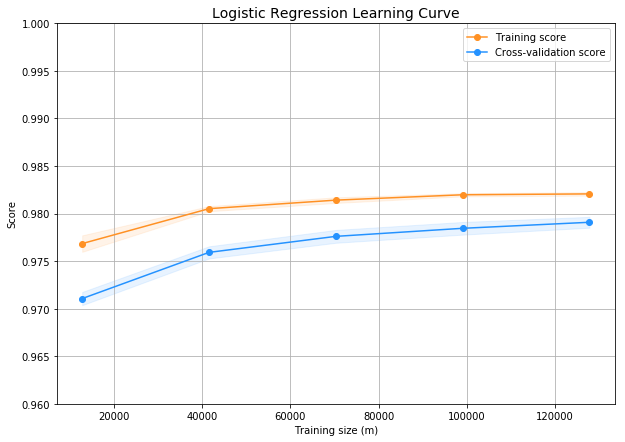

SMOTE


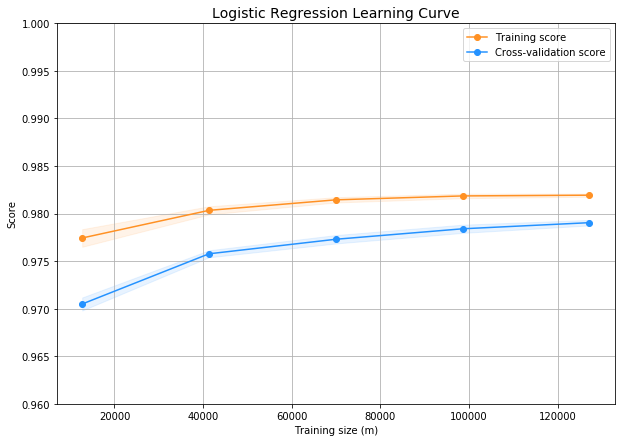

In [158]:
for method_name, method in oversampling_lgm.items():
    print(method_name)
    
over_method = method
X_resampled, y_resampled = over_method.fit_sample(X_important_features, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.30, random_state=59)

lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                    reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=42)
plot_learning_curve(lgbc, X_train, y_train, (0.96, 1), cv=cv, n_jobs=4)
    

In [539]:
# specify your configurations as a dict
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss', 'auc'},
    'metric_freq': 1,
    'is_training_metric': True,
    'max_bin': 255,
    'learning_rate': 0.1,
    'num_leaves': 63,
    'tree_learner': 'serial',
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_data_in_leaf': 50,
    'min_sum_hessian_in_leaf': 5,
    'is_enable_sparse': True,
    'use_two_round_loading': False,
    'is_save_binary_file': False,
    'num_machines': 1,
    'local_listen_port': 12400,
    'verbose': 0,
    'subsample_for_bin': 200000,
    'min_child_samples': 20,
    'min_child_weight': 0.001,
    'min_split_gain': 0.0,
    'colsample_bytree': 1.0,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0
}

In [547]:
import lightgbm as lgb
over_method = ADASYN(sampling_strategy=1)
X_resampled, y_resampled = over_method.fit_sample(X_important_features, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.30, random_state=59)

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# train
gbm = lgb.train(params,
                lgb_train,
                valid_sets=lgb_eval)

gridParams = {
    'learning_rate': [ 0.1],
    'num_leaves': [63],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary']
}

mdl = lgb.LGBMClassifier(
    task = params['task'],
    metric = params['metric'],
    metric_freq = params['metric_freq'],
    is_training_metric = params['is_training_metric'],
    max_bin = params['max_bin'],
    tree_learner = params['tree_learner'],
    feature_fraction = params['feature_fraction'],
    bagging_fraction = params['bagging_fraction'],
    bagging_freq = params['bagging_freq'],
    min_data_in_leaf = params['min_data_in_leaf'],
    min_sum_hessian_in_leaf = params['min_sum_hessian_in_leaf'],
    is_enable_sparse = params['is_enable_sparse'],
    use_two_round_loading = params['use_two_round_loading'],
    is_save_binary_file = params['is_save_binary_file'],
    n_jobs = -1
)

scoring = {'AUC': 'roc_auc'}

# Create the grid
grid = GridSearchCV(mdl, gridParams, verbose=2, cv=5, scoring=scoring, n_jobs=-1, refit='AUC')
# Run the grid
grid.fit(X, y)

print('Best parameters found by grid search are:', grid.best_params_)
print('Best score found by grid search is:', grid.best_score_)

[1]	valid_0's auc: 0.978379	valid_0's binary_logloss: 0.613338
[2]	valid_0's auc: 0.985048	valid_0's binary_logloss: 0.547542
[3]	valid_0's auc: 0.985389	valid_0's binary_logloss: 0.492257
[4]	valid_0's auc: 0.986054	valid_0's binary_logloss: 0.445211
[5]	valid_0's auc: 0.987171	valid_0's binary_logloss: 0.404284
[6]	valid_0's auc: 0.987255	valid_0's binary_logloss: 0.370183
[7]	valid_0's auc: 0.987457	valid_0's binary_logloss: 0.34033
[8]	valid_0's auc: 0.988043	valid_0's binary_logloss: 0.313175
[9]	valid_0's auc: 0.988784	valid_0's binary_logloss: 0.290443
[10]	valid_0's auc: 0.989072	valid_0's binary_logloss: 0.269166
[11]	valid_0's auc: 0.989245	valid_0's binary_logloss: 0.250969
[12]	valid_0's auc: 0.989597	valid_0's binary_logloss: 0.23475
[13]	valid_0's auc: 0.989705	valid_0's binary_logloss: 0.220455
[14]	valid_0's auc: 0.99039	valid_0's binary_logloss: 0.207752
[15]	valid_0's auc: 0.990477	valid_0's binary_logloss: 0.195939
[16]	valid_0's auc: 0.99072	valid_0's binary_logloss

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


TypeError: unsupported operand type(s) for +: 'set' and 'list'